In [60]:
import torch
import numpy as np
import random
import pennylane as qml

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    #qml.settings.random_seed = seed  # Set seed for PennyLane pseudorandomness

set_seed()  # Call this once at the start of your script or notebook

# Then run your QGNN model initialization and training/testing as usual


In [61]:
import pennylane as qml
from pennylane import numpy as np
import torch
import networkx as nx
import torch_geometric
import numpy as onp  # for number conversion only


class PennyLaneQGNN(torch.nn.Module):
    def __init__(self, n_qubits=1, n_nodes=6, device='default.qubit', verbose=False):
        super(PennyLaneQGNN, self).__init__()
        self.verbose = verbose
        self.n_qubits = n_qubits
        self.n_nodes = n_nodes
        self.total_qubits = n_qubits * n_nodes
        self.dev = qml.device(device, wires=self.total_qubits)

        # Initialize rotation angles for CZ gates as trainable parameters
        self.rots = torch.nn.Parameter(torch.rand(n_qubits, n_qubits) * 2 * np.pi)

    def circuit(self, edges, rots_values):
        # Start in uniform superposition: Hadamard on all qubits
        for wire in range(self.total_qubits):
            qml.Hadamard(wires=wire)

        # Apply controlled phase rotations for edges and qubit pairs
        for e in range(edges.shape[1]):
            u = edges[0][e].item()
            v = edges[1][e].item()
            for l in range(self.n_qubits):
                for r in range(self.n_qubits):
                    ql = u * self.n_qubits + l
                    qr = v * self.n_qubits + r
                    angle = rots_values[l][r]
                    # Controlled RZ as controlled phase rotation
                    qml.ctrl(qml.RZ, control=ql)(angle, wires=qr)

        return qml.probs(wires=range(self.total_qubits))

    def forward(self, graph):
        edges = graph.edge_index
        rots_values = self.rots

        @qml.qnode(self.dev, interface='torch')
        def qnode():
            return self.circuit(edges, rots_values)

        probs = qnode()

        # Group probabilities by Hamming weight (# of ones)
        counts = torch.zeros(self.total_qubits + 1, dtype=torch.float32)
        for i, p in enumerate(probs):
            ones = bin(i).count('1')
            counts[ones] += p

        if self.verbose:
            print("Probability counts by number of ones:", counts.detach().numpy())

        return counts


# Helper: Convert nx graph to PyG Data (as in your original code)
def to_pyg(g, label):
    data = torch_geometric.utils.from_networkx(g)
    data.x = torch.zeros((g.number_of_nodes(), 50))
    data.y = torch.tensor([label])
    return data


# Original PyTorch raw simulator QGNN (for comparison)
class RawQGNN(torch.nn.Module):
    def __init__(self, n_qubits=1, n_nodes=6, verbose=False):
        super(RawQGNN, self).__init__()
        self.verbose = verbose
        self.n_qubits = n_qubits
        self.n_nodes = n_nodes
        self.rots = torch.rand(n_qubits, n_qubits) * 2 * np.pi  # random angles
        self.total_qubits = n_qubits * n_nodes
        self.state_dim = 2 ** self.total_qubits

    def forward(self, graph):
        edges = graph.edge_index
        state = torch.ones(self.state_dim, dtype=torch.cfloat) / (2 ** (self.total_qubits / 2))

        for edge in range(edges.shape[1]):
            for l in range(self.n_qubits):
                for r in range(self.n_qubits):
                    ql = (edges[0][edge] * self.n_qubits + l).numpy()
                    qr = (edges[1][edge] * self.n_qubits + r).numpy()
                    for s in range(self.state_dim):
                        if (s & (1 << ql)) and (s & (1 << qr)):
                            state[s] *= torch.exp(self.rots[l][r] * 1j)

        out = torch.zeros(self.state_dim, dtype=torch.cfloat)
        norm = 1 / (2 ** (self.total_qubits / 2))
        for s in range(self.state_dim):
            for t in range(self.state_dim):
                weight = state[s] * norm
                for i in range(self.total_qubits):
                    if (s & (1 << i)) and (t & (1 << i)):
                        weight *= -1
                out[t] += weight

        probs = torch.square(torch.abs(out))
        counts = torch.zeros(self.total_qubits + 1)
        for s in range(len(probs)):
            ones = 0
            for i in range(self.total_qubits):
                if (s & (1 << i)):
                    ones += 1
            counts[ones] += probs[s]

        if self.verbose:
            print("1-count distribution:", counts.numpy())

        return counts


# Testing code to compare outputs of both models

# Build example graph: 6-node cycle
G = nx.cycle_graph(6)
pyg_data = to_pyg(G, 1)

# Instantiate models
raw_model = RawQGNN(n_qubits=1, n_nodes=6, verbose=True)
pl_model = PennyLaneQGNN(n_qubits=1, n_nodes=6, verbose=True)

# To compare fairly, copy rotation parameters from raw_model to pl_model exactly
with torch.no_grad():
    pl_model.rots.copy_(raw_model.rots)

# Run raw model
raw_output = raw_model(pyg_data)
print("Raw QGNN output:", raw_output)

# Run PennyLane model
pl_output = pl_model(pyg_data)
print("PennyLane QGNN output:", pl_output)

# Compare outputs (numerical closeness)
difference = torch.norm(raw_output - pl_output)
print("Difference between outputs:", difference.item())


1-count distribution: [0.05856628 0.14005087 0.2106652  0.25696754 0.19055915 0.10298147
 0.04020983]
Raw QGNN output: tensor([0.0586, 0.1401, 0.2107, 0.2570, 0.1906, 0.1030, 0.0402])
Probability counts by number of ones: [0.015625   0.09374999 0.23437499 0.31249994 0.23437496 0.09374996
 0.01562499]
PennyLane QGNN output: tensor([0.0156, 0.0937, 0.2344, 0.3125, 0.2344, 0.0937, 0.0156],
       grad_fn=<CopySlices>)
Difference between outputs: 0.1012086272239685


In [62]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
import random
import pennylane as qml

# For reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    #qml.settings.random_seed = seed

set_seed()


In [63]:
# Function to generate a cycle graph and create node features and node labels
def gen_cycle_graph_with_node_labels(n_nodes=6):
    G = nx.cycle_graph(n_nodes)
    
    # Node features: simple one-hot encoding of node index % feature_size
    feature_size = 10
    x = torch.zeros((n_nodes, feature_size))
    for i in range(n_nodes):
        x[i, i % feature_size] = 1.0

    # Node labels: label 0 if node degree == 2 (all nodes in cycle have degree 2)
    # For demo, let's assign label '1' to even nodes and '0' to odd nodes for variation
    y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(n_nodes)], dtype=torch.long)

    data = from_networkx(G)
    data.x = x
    data.y = y
    return data

# Prepare train/test datasets (here, just replicates for demonstration)
train_dataset = [gen_cycle_graph_with_node_labels(n_nodes=6)]
test_dataset = [gen_cycle_graph_with_node_labels(n_nodes=6)]


In [64]:
class PennyLaneQGNNNodeClassifier(torch.nn.Module):
    def __init__(self, n_qubits=1, n_nodes=6, n_classes=2, device='default.qubit', verbose=False):
        super(PennyLaneQGNNNodeClassifier, self).__init__()
        self.verbose = verbose
        self.n_qubits = n_qubits
        self.n_nodes = n_nodes
        self.n_classes = n_classes
        self.total_qubits = n_qubits * n_nodes
        self.dev = qml.device(device, wires=self.total_qubits)

        # Initialize trainable rotation angles for CZ gates
        self.rots = torch.nn.Parameter(torch.rand(n_qubits, n_qubits) * 2 * np.pi)

        # Simple MLP to map the measurement outcome counts per node to class logits
        # input_dim = n_nodes * (n_qubits + 1) [using counts grouped by number of ones per node qubit block]
        # Define MLP for node-wise classification
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_qubits + 1, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, n_classes)
        )



    def circuit(self, edges, rots_values):
        # Initialize all qubits in uniform superposition
        for wire in range(self.total_qubits):
            qml.Hadamard(wires=wire)

        # Controlled phase rotations per edge and qubit pair
        for e in range(edges.shape[1]):
            u = edges[0][e].item()
            v = edges[1][e].item()
            for l in range(self.n_qubits):
                for r in range(self.n_qubits):
                    ql = u * self.n_qubits + l
                    qr = v * self.n_qubits + r
                    angle = rots_values[l][r]
                    qml.ctrl(qml.RZ, control=ql)(angle, wires=qr)

        # Measure probabilities of all qubits
        return qml.probs(wires=range(self.total_qubits))

    def forward(self, graph):
        edges = graph.edge_index
        rots_values = self.rots

        @qml.qnode(self.dev, interface='torch')
        def qnode():
            return self.circuit(edges, rots_values)

        probs = qnode()

        per_node_counts = []
        for node in range(self.n_nodes):
            start = node * self.n_qubits
            end = (node + 1) * self.n_qubits
            counts_node = torch.zeros(self.n_qubits + 1, device=probs.device)
            for basis_idx, p in enumerate(probs):
                bitstring = format(basis_idx, f'0{self.total_qubits}b')
                sub_str = bitstring[-self.total_qubits:][start:end]
                ones_count = sub_str.count('1')
                counts_node[ones_count] += p
            per_node_counts.append(counts_node)

        x = torch.stack(per_node_counts)  # shape: [num_nodes, n_qubits + 1]

        logits = self.mlp(x)  # shape: [num_nodes, n_classes]

        return logits





In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = PennyLaneQGNNNodeClassifier(n_qubits=1, n_nodes=6, n_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Assume single graph in dataset with multiple nodes and node labels in data.y
data = train_dataset[0].to(device)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    # data.y is [n_nodes], get node-wise prediction for 2 classes
    loss = F.cross_entropy(out, data.y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 10, Loss: 0.6948
Epoch 20, Loss: 0.6936
Epoch 30, Loss: 0.6932
Epoch 40, Loss: 0.6932
Epoch 50, Loss: 0.6931
Epoch 60, Loss: 0.6931
Epoch 70, Loss: 0.6931
Epoch 80, Loss: 0.6931
Epoch 90, Loss: 0.6931
Epoch 100, Loss: 0.6931


In [66]:
model.eval()
test_data = test_dataset[0].to(device)
with torch.no_grad():
    logits = model(test_data)
    pred = logits.argmax(dim=1)
    correct = (pred == test_data.y).sum().item()
    acc = correct / test_data.y.size(0)
    print(f"Test Accuracy: {acc * 100:.2f}%")


Test Accuracy: 50.00%


In [67]:
import torch
import torch.nn.functional as F
import pennylane as qml
import numpy as np

class EnhancedPennyLaneQGNNNodeClassifier(torch.nn.Module):
    def __init__(self, n_qubits=1, n_nodes=6, n_layers=3, n_classes=2, device='default.qubit', verbose=False):
        super().__init__()
        self.verbose = verbose
        self.n_qubits = n_qubits
        self.n_nodes = n_nodes
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.total_qubits = n_qubits * n_nodes
        self.dev = qml.device(device, wires=self.total_qubits)

        # Rotation parameters: separate learnable tensors per layer for edge and node rotations
        self.edge_rots = torch.nn.ParameterList([
            torch.rand(n_qubits, n_qubits) * 2 * np.pi for _ in range(n_layers)
        ])
        self.node_rots = torch.nn.ParameterList([
            torch.rand(n_qubits) * 2 * np.pi for _ in range(n_layers)
        ])

        # MLP classifier (per node features)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_qubits + 1, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, n_classes)
        )

    def circuit(self, edges, edge_rots_values, node_rots_values):
        # Initialize uniform superposition on all qubits
        for w in range(self.total_qubits):
            qml.Hadamard(wires=w)

        for layer_idx in range(self.n_layers):
            # Node rotations (single-qubit Ry rotations) applied uniformly per node qubit
            for node in range(self.n_nodes):
                for q in range(self.n_qubits):
                    wire = node * self.n_qubits + q
                    qml.RY(node_rots_values[layer_idx][q], wires=wire)

            # Edge rotations: Controlled RZ rotations on edges conditioning on qubit pairs
            for e in range(edges.shape[1]):
                u = edges[0][e].item()
                v = edges[1][e].item()
                for l in range(self.n_qubits):
                    for r in range(self.n_qubits):
                        ql = u * self.n_qubits + l
                        qr = v * self.n_qubits + r
                        angle = edge_rots_values[layer_idx][l][r]
                        # controlled RZ gate: controlled by ql, acting on qr
                        qml.ctrl(qml.RZ, control=ql)(angle, wires=qr)

    def forward(self, graph):
        edges = graph.edge_index
        edge_rots_values = self.edge_rots
        node_rots_values = self.node_rots

        @qml.qnode(self.dev, interface='torch')
        def qnode():
            self.circuit(edges, edge_rots_values, node_rots_values)
            return qml.probs(wires=range(self.total_qubits))

        probs = qnode()

        # Extract per-node feature vector: counts grouped by #ones per node qubit block
        per_node_counts = []
        for node in range(self.n_nodes):
            start = node * self.n_qubits
            end = (node + 1) * self.n_qubits
            counts_node = torch.zeros(self.n_qubits + 1, device=probs.device)
            for basis_idx, p in enumerate(probs):
                bitstring = format(basis_idx, f'0{self.total_qubits}b')
                sub_str = bitstring[-self.total_qubits:][start:end]
                ones_count = sub_str.count('1')
                counts_node[ones_count] += p
            per_node_counts.append(counts_node)

        x = torch.stack(per_node_counts)  # shape: [num_nodes, n_qubits+1]
        logits = self.mlp(x)  # per-node class logits

        return logits


In [69]:
# =======================================
# 1. Imports & Reproducibility
# =======================================
import torch
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
import random
import pennylane as qml

# Make results reproducible
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    #qml.settings.random_seed = seed

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


# =======================================
# 2. Dataset Preparation (Node Classification)
# =======================================
def gen_cycle_graph_with_node_labels(n_nodes=6, feature_size=10):
    """Generates a cycle graph with simple features and parity-based labels."""
    G = nx.cycle_graph(n_nodes)

    # Node features: one-hot encoding
    x = torch.zeros((n_nodes, feature_size))
    for i in range(n_nodes):
        x[i, i % feature_size] = 1.0

    # Labels: 1 for even-indexed nodes, 0 for odd-indexed nodes
    y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(n_nodes)], dtype=torch.long)

    data = from_networkx(G)
    data.x = x
    data.y = y
    return data

# Train & test samples (same structure here for demo)
train_data = gen_cycle_graph_with_node_labels(6).to(device)
test_data = gen_cycle_graph_with_node_labels(6).to(device)


# =======================================
# 3. Enhanced PennyLane QGNN Model
# =======================================
class EnhancedPennyLaneQGNNNodeClassifier(torch.nn.Module):
    def __init__(self, n_qubits=1, n_nodes=6, n_layers=3, n_classes=2, device='default.qubit', verbose=False):
        super().__init__()
        self.verbose = verbose
        self.n_qubits = n_qubits
        self.n_nodes = n_nodes
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.total_qubits = n_qubits * n_nodes
        self.dev = qml.device(device, wires=self.total_qubits)

        # Trainable parameters
        self.edge_rots = torch.nn.ParameterList([
            torch.nn.Parameter(torch.rand(n_qubits, n_qubits) * 2 * np.pi) for _ in range(n_layers)
        ])
        self.node_rots = torch.nn.ParameterList([
            torch.nn.Parameter(torch.rand(n_qubits) * 2 * np.pi) for _ in range(n_layers)
        ])

        # MLP for per-node classification
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_qubits + 1, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, n_classes)
        )

    def circuit(self, edges, edge_rots_values, node_rots_values):
        # Start with uniform superposition
        for w in range(self.total_qubits):
            qml.Hadamard(wires=w)

        # Apply multiple QGNN layers
        for layer_idx in range(self.n_layers):
            # Node rotations
            for node in range(self.n_nodes):
                for q in range(self.n_qubits):
                    qml.RY(node_rots_values[layer_idx][q], wires=node*self.n_qubits + q)

            # Edge-controlled rotations
            for e in range(edges.shape[1]):
                u = edges[0][e].item()
                v = edges[1][e].item()
                for l in range(self.n_qubits):
                    for r in range(self.n_qubits):
                        ql = u * self.n_qubits + l
                        qr = v * self.n_qubits + r
                        angle = edge_rots_values[layer_idx][l][r]
                        qml.ctrl(qml.RZ, control=ql)(angle, wires=qr)

    def forward(self, graph):
        edges = graph.edge_index
        edge_rots_values = self.edge_rots
        node_rots_values = self.node_rots

        @qml.qnode(self.dev, interface='torch')
        def qnode():
            self.circuit(edges, edge_rots_values, node_rots_values)
            return qml.probs(wires=range(self.total_qubits))

        probs = qnode()

        # Aggregate per-node counts
        per_node_counts = []
        for node in range(self.n_nodes):
            start = node * self.n_qubits
            end = (node + 1) * self.n_qubits
            counts_node = torch.zeros(self.n_qubits + 1, device=probs.device)
            for basis_idx, p in enumerate(probs):
                bitstring = format(basis_idx, f'0{self.total_qubits}b')
                sub_str = bitstring[-self.total_qubits:][start:end]
                ones_count = sub_str.count('1')
                counts_node[ones_count] += p
            per_node_counts.append(counts_node)

        x = torch.stack(per_node_counts)  # [num_nodes, n_qubits+1]
        logits = self.mlp(x)              # [num_nodes, n_classes]
        return logits


# =======================================
# 4. Model Init & Training
# =======================================
model = EnhancedPennyLaneQGNNNodeClassifier(n_qubits=1, n_nodes=6, n_layers=3, n_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(1, 101):
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.cross_entropy(out, train_data.y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        pred = out.argmax(dim=1)
        acc = (pred == train_data.y).float().mean().item()
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Train Acc: {acc*100:.2f}%")


# =======================================
# 5. Evaluation
# =======================================
model.eval()
with torch.no_grad():
    out = model(test_data)
    pred = out.argmax(dim=1)
    acc = (pred == test_data.y).float().mean().item()
    print(f"Test Accuracy: {acc*100:.2f}%")


Using device: cuda
Epoch 010 | Loss: 0.6956 | Train Acc: 50.00%
Epoch 020 | Loss: 0.6932 | Train Acc: 50.00%
Epoch 030 | Loss: 0.6935 | Train Acc: 50.00%
Epoch 040 | Loss: 0.6931 | Train Acc: 50.00%
Epoch 050 | Loss: 0.6932 | Train Acc: 50.00%
Epoch 060 | Loss: 0.6932 | Train Acc: 50.00%
Epoch 070 | Loss: 0.6931 | Train Acc: 50.00%
Epoch 080 | Loss: 0.6931 | Train Acc: 50.00%
Epoch 090 | Loss: 0.6931 | Train Acc: 50.00%
Epoch 100 | Loss: 0.6931 | Train Acc: 50.00%
Test Accuracy: 50.00%


In [70]:
# =======================================
# 1. Imports & Reproducibility
# =======================================
import torch
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
import random
import pennylane as qml

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    #qml.settings.random_seed = seed

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


# =======================================
# 2. Dataset Generation with Asymmetry
# =======================================
def gen_dataset(num_graphs=100, n_nodes=6):
    dataset = []
    for _ in range(num_graphs):
        G = nx.cycle_graph(n_nodes)
        # Add 1 random edge to break symmetry
        possible_edges = list(nx.non_edges(G))
        if possible_edges:
            extra_edge = random.choice(possible_edges)
            G.add_edge(*extra_edge)

        # Classical node features: one-hot node ID + normalized degree
        feature_size = n_nodes + 1
        x = torch.zeros((n_nodes, feature_size))
        for i in range(n_nodes):
            x[i, i] = 1.0
            x[i, -1] = G.degree[i] / n_nodes

        # Labels: 1 if node degree >= average degree, else 0
        avg_deg = sum(dict(G.degree).values()) / n_nodes
        y = torch.tensor([1 if G.degree[i] >= avg_deg else 0 for i in range(n_nodes)], dtype=torch.long)

        data = from_networkx(G)
        data.x = x
        data.y = y
        dataset.append(data)
    return dataset

train_dataset = gen_dataset(num_graphs=100, n_nodes=6)
test_dataset = gen_dataset(num_graphs=20, n_nodes=6)


# =======================================
# 3. Enhanced Multi-layer QGNN Model with Hybrid Features
# =======================================
class EnhancedPennyLaneQGNNNodeClassifier(torch.nn.Module):
    def __init__(self, n_qubits=2, n_nodes=6, n_layers=5, n_classes=2, device='default.qubit', verbose=False, classical_feat_dim=7):
        super().__init__()
        self.verbose = verbose
        self.n_qubits = n_qubits
        self.n_nodes = n_nodes
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.total_qubits = n_qubits * n_nodes
        self.dev = qml.device(device, wires=self.total_qubits)

        # Learnable quantum rotations parameters per layer
        self.edge_rots = torch.nn.ParameterList([
            torch.nn.Parameter(torch.rand(n_qubits, n_qubits) * 2 * np.pi) for _ in range(n_layers)
        ])
        self.node_rots = torch.nn.ParameterList([
            torch.nn.Parameter(torch.rand(n_qubits) * 2 * np.pi) for _ in range(n_layers)
        ])

        # Hybrid MLP input size: quantum features + classical features
        input_dim = n_qubits + 1 + classical_feat_dim

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, n_classes)
        )

    def circuit(self, edges, edge_rots_values, node_rots_values):
        # Initialize uniform superposition on all qubits
        for w in range(self.total_qubits):
            qml.Hadamard(wires=w)

        for layer_idx in range(self.n_layers):
            # Node single-qubit rotations
            for node in range(self.n_nodes):
                for q in range(self.n_qubits):
                    qml.RY(node_rots_values[layer_idx][q], wires=node * self.n_qubits + q)

            # Edge-controlled rotations
            for e in range(edges.shape[1]):
                u = edges[0][e].item()
                v = edges[1][e].item()
                for l in range(self.n_qubits):
                    for r in range(self.n_qubits):
                        ql = u * self.n_qubits + l
                        qr = v * self.n_qubits + r
                        angle = edge_rots_values[layer_idx][l][r]
                        qml.ctrl(qml.RZ, control=ql)(angle, wires=qr)

    def forward(self, graph):
        edges = graph.edge_index
        edge_rots_values = self.edge_rots
        node_rots_values = self.node_rots

        @qml.qnode(self.dev, interface='torch')
        def qnode():
            self.circuit(edges, edge_rots_values, node_rots_values)
            return qml.probs(wires=range(self.total_qubits))

        probs = qnode()

        # Aggregate per-node quantum measurement counts (hamming weights)
        per_node_counts = []
        for node in range(self.n_nodes):
            start = node * self.n_qubits
            end = (node + 1) * self.n_qubits
            counts_node = torch.zeros(self.n_qubits + 1, device=probs.device)
            for basis_idx, p in enumerate(probs):
                bitstring = format(basis_idx, f'0{self.total_qubits}b')
                sub_str = bitstring[-self.total_qubits:][start:end]
                ones_count = sub_str.count('1')
                counts_node[ones_count] += p
            per_node_counts.append(counts_node)

        x_quantum = torch.stack(per_node_counts)  # shape: [num_nodes, n_qubits+1]

        # Add classical node features
        x_classical = graph.x.to(probs.device)
        x = torch.cat([x_quantum, x_classical], dim=1)  # shape: [num_nodes, quantum_features + classical_features]

        logits = self.mlp(x)  # per-node logits
        return logits


# =======================================
# 4. Training Loop Over Multiple Graphs
# =======================================
model = EnhancedPennyLaneQGNNNodeClassifier(
    n_qubits=2,
    n_nodes=6,
    n_layers=5,
    n_classes=2,
    classical_feat_dim=train_dataset[0].x.shape[1]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_nodes = 0

    for data in train_dataset:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (out.argmax(dim=1) == data.y).sum().item()
        total_nodes += data.y.size(0)

    if epoch % 10 == 0 or epoch == 1:
        train_acc = total_correct / total_nodes * 100
        avg_loss = total_loss / len(train_dataset)
        print(f'Epoch {epoch:03d} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}%')


# =======================================
# 5. Evaluation on Test Dataset
# =======================================
model.eval()
total_correct = 0
total_nodes = 0

with torch.no_grad():
    for data in test_dataset:
        data = data.to(device)
        out = model(data)
        total_correct += (out.argmax(dim=1) == data.y).sum().item()
        total_nodes += data.y.size(0)

test_acc = total_correct / total_nodes * 100
print(f'Test Accuracy: {test_acc:.2f}%')


Using device: cuda
Epoch 001 | Loss: 0.1653 | Train Acc: 93.00%
Epoch 010 | Loss: 0.0000 | Train Acc: 100.00%
Epoch 020 | Loss: 0.0000 | Train Acc: 100.00%


KeyboardInterrupt: 

In [71]:
# =======================================
# 5. Evaluation on Test Dataset
# =======================================
model.eval()
total_correct = 0
total_nodes = 0

with torch.no_grad():
    for data in test_dataset:
        data = data.to(device)
        out = model(data)
        total_correct += (out.argmax(dim=1) == data.y).sum().item()
        total_nodes += data.y.size(0)

test_acc = total_correct / total_nodes * 100
print(f'Test Accuracy: {test_acc:.2f}%')


Test Accuracy: 100.00%


In [72]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import networkx as nx

# Generate cycle graph with one-hot node features and parity labels
def gen_cycle_graph_with_node_labels(n_nodes=6):
    G = nx.cycle_graph(n_nodes)
    x = torch.zeros((n_nodes, 10))
    for i in range(n_nodes):
        x[i, i % 10] = 1.0
    y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(n_nodes)], dtype=torch.long)
    data = from_networkx(G)
    data.x = x
    data.y = y
    return data

train_data = gen_cycle_graph_with_node_labels(6)

# Define simple 2-layer GCN model
class SimpleGCN(torch.nn.Module):
    def __init__(self, input_dim=10, hidden_dim=16, output_dim=2):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = SimpleGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop for the single graph
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.cross_entropy(out, train_data.y)
    loss.backward()
    optimizer.step()

# Evaluate accuracy on training graph (no test split here for equivalence)
model.eval()
with torch.no_grad():
    pred = model(train_data).argmax(dim=1)
    accuracy = (pred == train_data.y).float().mean().item()
print(f'Classical GCN node classification accuracy: {accuracy*100:.2f}%')


Classical GCN node classification accuracy: 100.00%


Using device: cuda
Sample training graph:


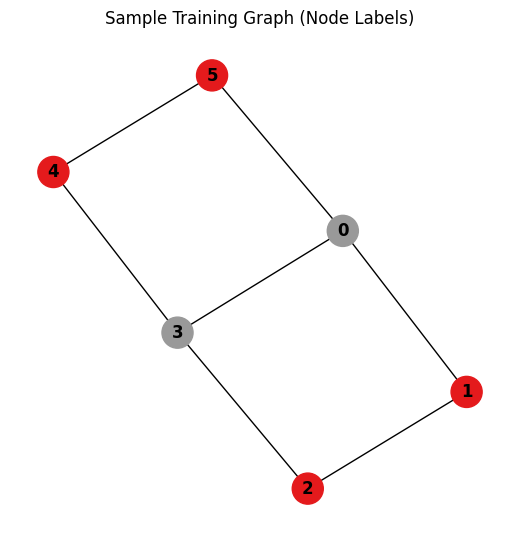

Sample test graph:


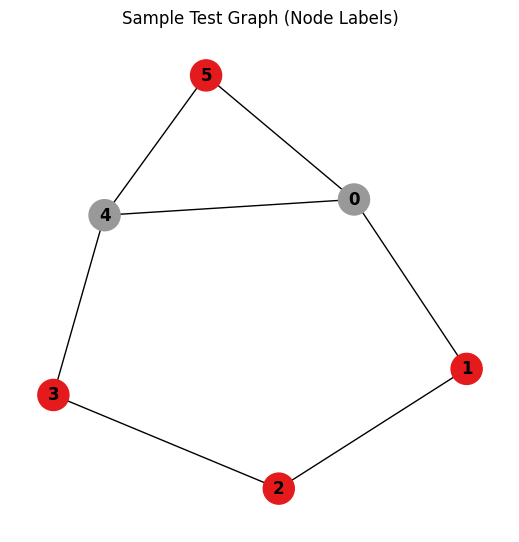

Epoch 001 | Loss: 0.6413 | Acc: 66.67% | Time per epoch: 0.08s
Epoch 010 | Loss: 0.3271 | Acc: 97.50% | Time per epoch: 0.08s
Classical GCN training time: 0.82 seconds
Classical GCN Test Accuracy: 96.67%
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9500    0.9744        80
           1     0.9091    1.0000    0.9524        40

    accuracy                         0.9667       120
   macro avg     0.9545    0.9750    0.9634       120
weighted avg     0.9697    0.9667    0.9670       120

Epoch 001 | Loss: 0.4651 | Acc: 73.89% | Time per epoch: 157.41s
Epoch 010 | Loss: 0.0000 | Acc: 100.00% | Time per epoch: 158.46s
Quantum QGNN training time: 1580.24 seconds
Quantum QGNN Test Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        80
           1     1.0000    1.0000    1.0000        40

    accuracy                         1.0000     

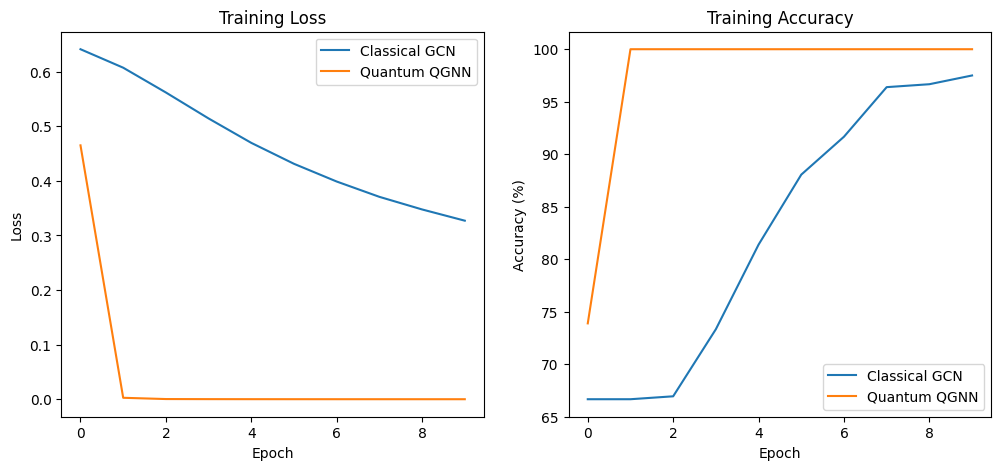

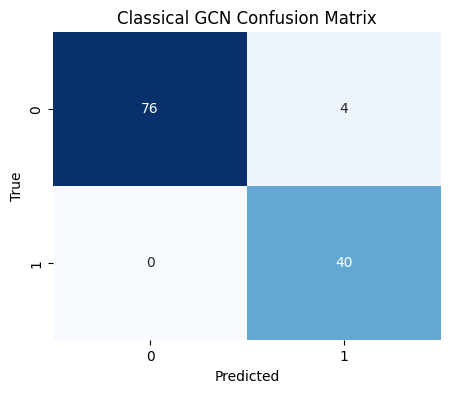

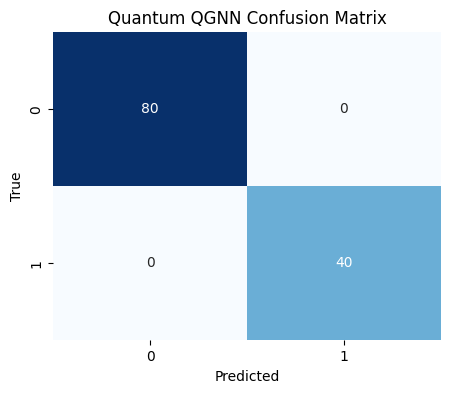

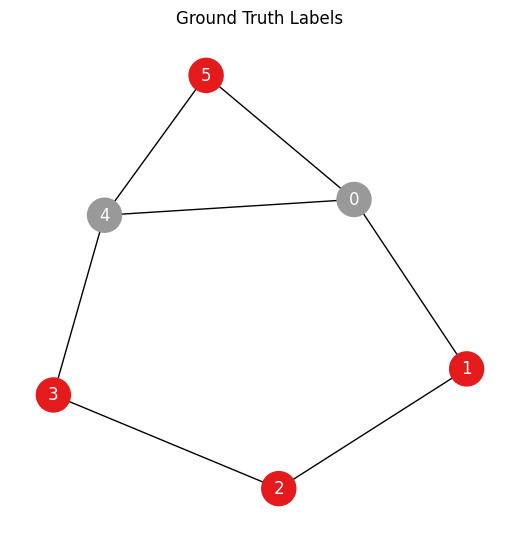

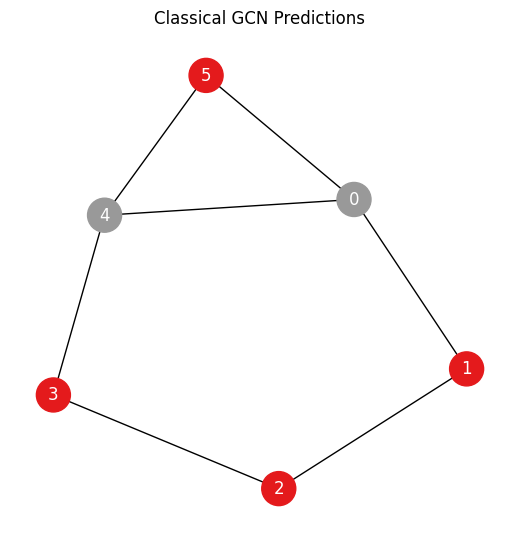

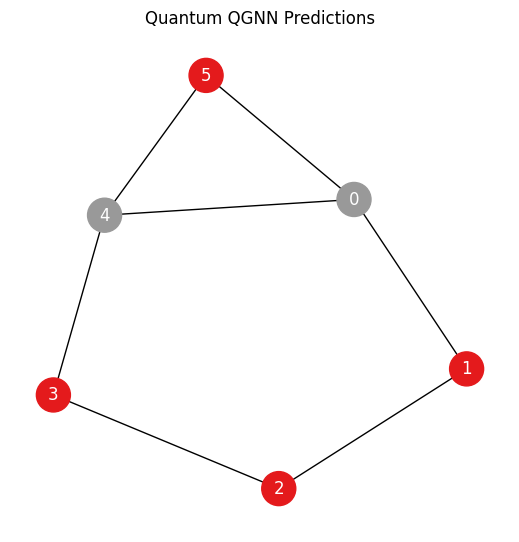

Classical GCN parameters: 162
Quantum QGNN parameters: 864
Classical GCN layers: 2 (GCNConv layers)
Quantum QGNN layers: 5 quantum layers + 2 MLP layers
Classical Training time: 0.82 s
Quantum Training time: 1580.24 s


In [77]:
# =======================================
# Cell 1: Imports & Reproducibility
# =======================================
import torch
import torch.nn.functional as F
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.nn import GCNConv
import networkx as nx
import numpy as np
import random
import copy
import pennylane as qml
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import time

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
   # qml.settings.random_seed = seed

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# =======================================
# Cell 2: Dataset Generation & Visualization
# =======================================
def gen_dataset(num_graphs=60, n_nodes=6):
    dataset = []
    for _ in range(num_graphs):
        G = nx.cycle_graph(n_nodes)
        possible_edges = list(nx.non_edges(G))
        if possible_edges:
            extra_edge = random.choice(possible_edges)
            G.add_edge(*extra_edge)

        feature_size = n_nodes + 1
        x = torch.zeros((n_nodes, feature_size))
        for i in range(n_nodes):
            x[i, i] = 1.0
            x[i, -1] = G.degree[i] / n_nodes

        avg_deg = sum(dict(G.degree).values()) / n_nodes
        y = torch.tensor([1 if G.degree[i] >= avg_deg else 0 for i in range(n_nodes)], dtype=torch.long)

        data = from_networkx(G)
        data.x = x
        data.y = y
        dataset.append(data)
    return dataset

train_dataset = gen_dataset(60)
test_dataset = gen_dataset(20)

def visualize_graph(data, title="Graph Visualization"):
    G = to_networkx(data, to_undirected=True)
    plt.figure(figsize=(5,5))
    pos = nx.spring_layout(G, seed=42)
    labels = data.y.cpu().numpy()
    cmap = plt.cm.Set1
    nx.draw(G, pos, with_labels=True, node_color=labels, cmap=cmap, node_size=500, font_weight='bold')
    plt.title(title)
    plt.show()

print("Sample training graph:")
visualize_graph(train_dataset[0], "Sample Training Graph (Node Labels)")

print("Sample test graph:")
visualize_graph(test_dataset[0], "Sample Test Graph (Node Labels)")


# =======================================
# Cell 3: Classical 2-layer GCN Model
# =======================================
class ClassicalGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=16, output_dim=2):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

input_dim = train_dataset[0].x.shape[1]
classical_model = ClassicalGCN(input_dim).to(device)


# =======================================
# Cell 4: Enhanced PennyLane QGNN Model
# =======================================
class EnhancedPennyLaneQGNNNodeClassifier(torch.nn.Module):
    def __init__(self, n_qubits=2, n_nodes=6, n_layers=5, n_classes=2, device='default.qubit', classical_feat_dim=7):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_nodes = n_nodes
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.total_qubits = n_qubits * n_nodes
        self.dev = qml.device(device, wires=self.total_qubits)

        self.edge_rots = torch.nn.ParameterList([
            torch.nn.Parameter(torch.rand(n_qubits, n_qubits) * 2 * np.pi) for _ in range(n_layers)
        ])
        self.node_rots = torch.nn.ParameterList([
            torch.nn.Parameter(torch.rand(n_qubits) * 2 * np.pi) for _ in range(n_layers)
        ])

        input_dim = n_qubits + 1 + classical_feat_dim
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, n_classes)
        )

    def circuit(self, edges, edge_rots_values, node_rots_values):
        for w in range(self.total_qubits):
            qml.Hadamard(wires=w)
        for layer_idx in range(self.n_layers):
            for node in range(self.n_nodes):
                for q in range(self.n_qubits):
                    qml.RY(node_rots_values[layer_idx][q], wires=node * self.n_qubits + q)
            for e in range(edges.shape[1]):
                u, v = edges[0][e].item(), edges[1][e].item()
                for l in range(self.n_qubits):
                    for r in range(self.n_qubits):
                        ql = u * self.n_qubits + l
                        qr = v * self.n_qubits + r
                        qml.ctrl(qml.RZ, control=ql)(edge_rots_values[layer_idx][l][r], wires=qr)

    def forward(self, graph):
        edges = graph.edge_index
        edge_rots_values = self.edge_rots
        node_rots_values = self.node_rots

        @qml.qnode(self.dev, interface='torch')
        def qnode():
            self.circuit(edges, edge_rots_values, node_rots_values)
            return qml.probs(wires=range(self.total_qubits))

        probs = qnode()
        per_node_counts = []
        for node in range(self.n_nodes):
            start = node * self.n_qubits
            end = (node + 1) * self.n_qubits
            counts_node = torch.zeros(self.n_qubits + 1, device=probs.device)
            for basis_idx, p in enumerate(probs):
                bitstring = format(basis_idx, f'0{self.total_qubits}b')
                ones_count = bitstring[-self.total_qubits:][start:end].count('1')
                counts_node[ones_count] += p
            per_node_counts.append(counts_node)

        x_quantum = torch.stack(per_node_counts)
        x_classical = graph.x.to(probs.device)
        x = torch.cat([x_quantum, x_classical], dim=1)
        logits = self.mlp(x)
        return logits

quantum_model = EnhancedPennyLaneQGNNNodeClassifier(
    n_qubits=2,
    n_nodes=6,
    n_layers=5,
    n_classes=2,
    classical_feat_dim=train_dataset[0].x.shape[1]
).to(device)

# =======================================
# Cell 5: Utility function to train models
# =======================================
def train(model, dataset, num_epochs=10, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    losses = []
    accuracies = []
    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        total_correct = 0
        total_nodes = 0
        start_time = time.time()
        for data in dataset:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.cross_entropy(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += (out.argmax(dim=1) == data.y).sum().item()
            total_nodes += data.y.size(0)
        epoch_loss = total_loss / len(dataset)
        epoch_acc = total_correct / total_nodes
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        if epoch % 10 == 0 or epoch == 1:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch:03d} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc*100:.2f}% | Time per epoch: {elapsed:.2f}s")
    return losses, accuracies

def evaluate(model, dataset):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in dataset:
            data = data.to(device)
            out = model(data)
            preds = out.argmax(dim=1).cpu()
            y_pred.extend(preds.numpy())
            y_true.extend(data.y.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, digits=4)
    return acc, cm, cr, y_true, y_pred


# =======================================
# Cell 6: Train Classical GCN& Evaluate & Time
# =======================================
start = time.time()
classical_train_losses, classical_train_accs = train(classical_model, train_dataset, num_epochs=10, lr=0.01)
classical_train_time = time.time() - start
print(f"Classical GCN training time: {classical_train_time:.2f} seconds")
classical_test_acc, classical_cm, classical_cr, classical_ytrue, classical_ypred = evaluate(classical_model, test_dataset)
print(f"Classical GCN Test Accuracy: {classical_test_acc*100:.2f}%\nClassification Report:\n{classical_cr}")

# =======================================
# Cell 7: Train Quantum QGNN & Evaluate & Time
# =======================================
start = time.time()
quantum_train_losses, quantum_train_accs = train(quantum_model, train_dataset, num_epochs=10, lr=0.01)
quantum_train_time = time.time() - start
print(f"Quantum QGNN training time: {quantum_train_time:.2f} seconds")
quantum_test_acc, quantum_cm, quantum_cr, quantum_ytrue, quantum_ypred = evaluate(quantum_model, test_dataset)
print(f"Quantum QGNN Test Accuracy: {quantum_test_acc*100:.2f}%\nClassification Report:\n{quantum_cr}")


# =======================================
# Cell 8: Visualization - Training Curves
# =======================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(classical_train_losses, label='Classical GCN')
plt.plot(quantum_train_losses, label='Quantum QGNN')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot([a*100 for a in classical_train_accs], label='Classical GCN')
plt.plot([a*100 for a in quantum_train_accs], label='Quantum QGNN')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


# =======================================
# Cell 9: Visualization - Confusion Matrices
# =======================================
def plot_confusion(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion(classical_cm, "Classical GCN Confusion Matrix")
plot_confusion(quantum_cm, "Quantum QGNN Confusion Matrix")


# =======================================
# Cell 10: Visualization - Predictions vs Ground Truth on Sample Graph
# =======================================
sample_test_data = test_dataset[0].to(device)
classical_model.eval()
quantum_model.eval()

with torch.no_grad():
    classical_logits = classical_model(sample_test_data).argmax(dim=1).cpu().numpy()
    quantum_logits = quantum_model(sample_test_data).argmax(dim=1).cpu().numpy()
true_labels = sample_test_data.y.cpu().numpy()

G_sample = to_networkx(sample_test_data, to_undirected=True)
pos = nx.spring_layout(G_sample, seed=42)

def plot_prediction_graph(G, labels, title="Graph", pos=None):
    plt.figure(figsize=(5,5))
    cmap = plt.cm.Set1
    nx.draw(G, pos, with_labels=True, node_color=labels, cmap=cmap, node_size=600, font_color='white')
    plt.title(title)
    plt.show()

plot_prediction_graph(G_sample, true_labels, "Ground Truth Labels", pos)
plot_prediction_graph(G_sample, classical_logits, "Classical GCN Predictions", pos)
plot_prediction_graph(G_sample, quantum_logits, "Quantum QGNN Predictions", pos)


# =======================================
# Cell 11: Parameters and Model Summary
# =======================================
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Classical GCN parameters: {count_parameters(classical_model)}")
print(f"Quantum QGNN parameters: {count_parameters(quantum_model)}")

print(f"Classical GCN layers: 2 (GCNConv layers)")
print(f"Quantum QGNN layers: {quantum_model.n_layers} quantum layers + 2 MLP layers")

print(f"Classical Training time: {classical_train_time:.2f} s")
print(f"Quantum Training time: {quantum_train_time:.2f} s")


In [8]:
!pip install scikit-learn seaborn matplotlib networkx 

  Using cached scikit_learn-1.7.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached pandas-2.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached scikit_learn-1.7.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.5 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
Using cached pandas-2.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.0 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-an

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.nn import GCNConv
import networkx as nx
import numpy as np
import random
import pennylane as qml
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import time

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    #qml.settings.random_seed = seed

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Sample training graph:


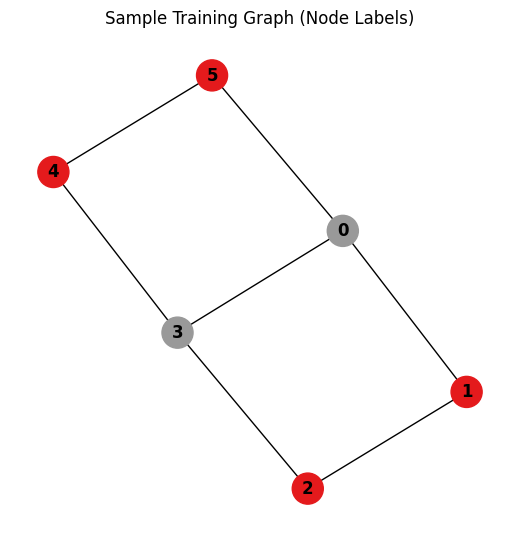

In [11]:
def gen_dataset(num_graphs=60, n_nodes=6):
    dataset = []
    for _ in range(num_graphs):
        G = nx.cycle_graph(n_nodes)
        possible_edges = list(nx.non_edges(G))
        if possible_edges:
            extra_edge = random.choice(possible_edges)
            G.add_edge(*extra_edge)

        feature_size = n_nodes + 1
        x = torch.zeros((n_nodes, feature_size))
        for i in range(n_nodes):
            x[i, i] = 1.0
            x[i, -1] = G.degree[i] / n_nodes

        avg_deg = sum(dict(G.degree).values()) / n_nodes
        y = torch.tensor([1 if G.degree[i] >= avg_deg else 0 for i in range(n_nodes)], dtype=torch.long)

        data = from_networkx(G)
        data.x = x
        data.y = y
        dataset.append(data)
    return dataset

train_dataset = gen_dataset(60)
test_dataset = gen_dataset(20)

def visualize_graph(data, title="Graph Visualization"):
    G = to_networkx(data, to_undirected=True)
    plt.figure(figsize=(5,5))
    pos = nx.spring_layout(G, seed=42)
    labels = data.y.cpu().numpy()
    cmap = plt.cm.Set1
    nx.draw(G, pos, with_labels=True, node_color=labels, cmap=cmap, node_size=500, font_weight='bold')
    plt.title(title)
    plt.show()

print("Sample training graph:")
visualize_graph(train_dataset[0], "Sample Training Graph (Node Labels)")


In [12]:
class ClassicalGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=16, output_dim=2):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

input_dim = train_dataset[0].x.shape[1]
classical_model = ClassicalGCN(input_dim).to(device)


In [13]:
class SimpleQGNN(torch.nn.Module):
    def __init__(self, n_qubits=1, n_nodes=6, n_classes=2, device='default.qubit', classical_feat_dim=7):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_nodes = n_nodes
        self.n_classes = n_classes
        self.total_qubits = n_qubits * n_nodes
        self.dev = qml.device(device, wires=self.total_qubits)

        # Single layer quantum circuit params
        self.node_rots = torch.nn.Parameter(torch.rand(n_qubits) * 2 * np.pi)
        self.edge_rots = torch.nn.Parameter(torch.rand(n_qubits, n_qubits) * 2 * np.pi)

        input_dim = n_qubits + 1 + classical_feat_dim
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, n_classes)
        )

    def circuit(self, edges, node_rots_values, edge_rots_values):
        for w in range(self.total_qubits):
            qml.Hadamard(wires=w)
        # Node single-qubit rotations (Ry)
        for node in range(self.n_nodes):
            for q in range(self.n_qubits):
                qml.RY(node_rots_values[q], wires=node * self.n_qubits + q)
        # Edge-controlled rotations (controlled RZ)
        for e in range(edges.shape[1]):
            u, v = edges[0][e].item(), edges[1][e].item()
            for l in range(self.n_qubits):
                for r in range(self.n_qubits):
                    ql = u * self.n_qubits + l
                    qr = v * self.n_qubits + r
                    qml.ctrl(qml.RZ, control=ql)(edge_rots_values[l][r], wires=qr)

    def forward(self, graph):
        edges = graph.edge_index
        node_rots_values = self.node_rots
        edge_rots_values = self.edge_rots

        @qml.qnode(self.dev, interface='torch')
        def qnode():
            self.circuit(edges, node_rots_values, edge_rots_values)
            return qml.probs(wires=range(self.total_qubits))

        probs = qnode()
        per_node_counts = []
        for node in range(self.n_nodes):
            start = node * self.n_qubits
            end = (node + 1) * self.n_qubits
            counts_node = torch.zeros(self.n_qubits + 1, device=probs.device)
            for basis_idx, p in enumerate(probs):
                bitstring = format(basis_idx, f'0{self.total_qubits}b')
                ones_count = bitstring[-self.total_qubits:][start:end].count('1')
                counts_node[ones_count] += p
            per_node_counts.append(counts_node)

        x_quantum = torch.stack(per_node_counts)
        x_classical = graph.x.to(probs.device)
        x = torch.cat([x_quantum, x_classical], dim=1)
        logits = self.mlp(x)
        return logits

simple_qgnn = SimpleQGNN(
    n_qubits=1, n_nodes=6, n_classes=2, classical_feat_dim=train_dataset[0].x.shape[1]
).to(device)


In [14]:
def train(model, dataset, num_epochs=50, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    losses, accuracies = [], []
    for epoch in range(1, num_epochs+1):
        total_loss, total_correct, total_nodes = 0, 0, 0
        start_time = time.time()
        for data in dataset:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.cross_entropy(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += (out.argmax(dim=1) == data.y).sum().item()
            total_nodes += data.y.size(0)
        epoch_loss = total_loss / len(dataset)
        epoch_acc = total_correct / total_nodes
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        if epoch % 10 == 0 or epoch == 1:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch:03d} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc*100:.2f}% | Time per epoch: {elapsed:.2f}s")
    return losses, accuracies

def evaluate(model, dataset):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in dataset:
            data = data.to(device)
            out = model(data)
            preds = out.argmax(dim=1).cpu()
            y_pred.extend(preds.numpy())
            y_true.extend(data.y.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, digits=4)
    return acc, cm, cr, y_true, y_pred


In [15]:
print("Training Classical GCN:")
classical_train_losses, classical_train_accs = train(classical_model, train_dataset, num_epochs=10, lr=0.01)
classical_test_acc, classical_cm, classical_cr, classical_ytrue, classical_ypred = evaluate(classical_model, test_dataset)

print("\nTraining Simple QGNN:")
simple_qgnn_train_losses, simple_qgnn_train_accs = train(simple_qgnn, train_dataset, num_epochs=10, lr=0.01)
simple_qgnn_test_acc, simple_qgnn_cm, simple_qgnn_cr, simple_qgnn_ytrue, simple_qgnn_ypred = evaluate(simple_qgnn, test_dataset)


Training Classical GCN:
Epoch 001 | Loss: 0.6413 | Acc: 66.67% | Time per epoch: 0.33s
Epoch 010 | Loss: 0.3271 | Acc: 97.50% | Time per epoch: 0.08s

Training Simple QGNN:
Epoch 001 | Loss: 0.6288 | Acc: 64.44% | Time per epoch: 3.36s
Epoch 010 | Loss: 0.0030 | Acc: 100.00% | Time per epoch: 2.93s


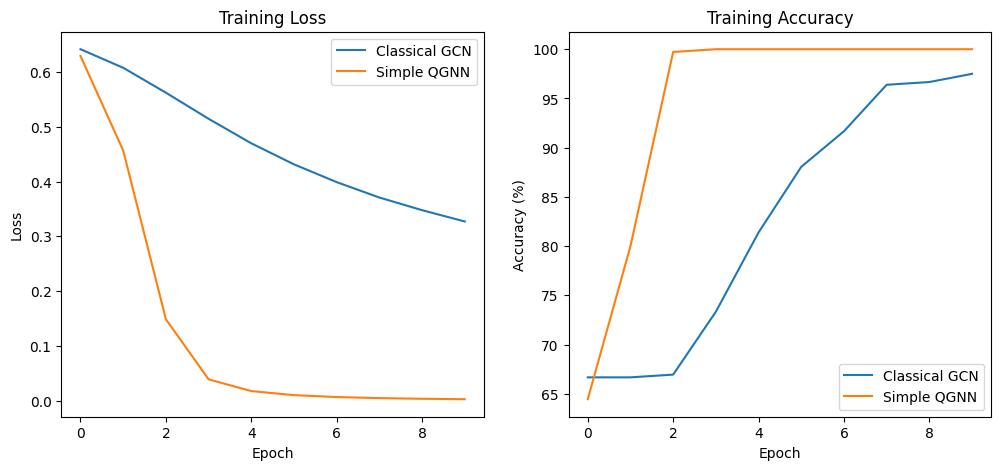

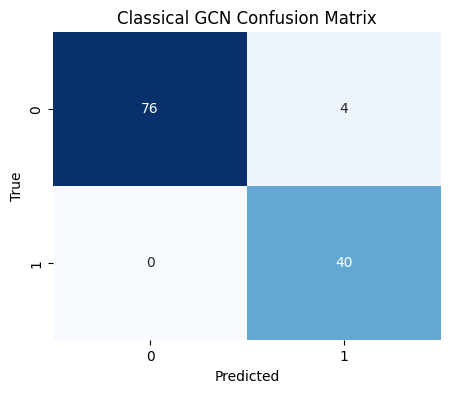

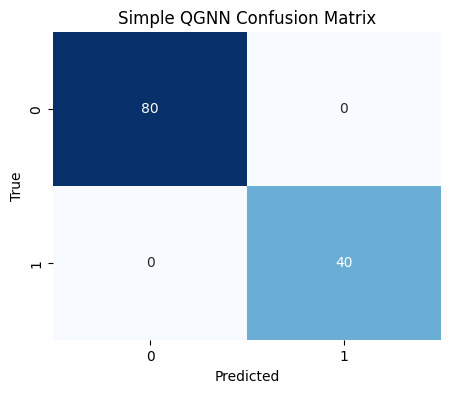

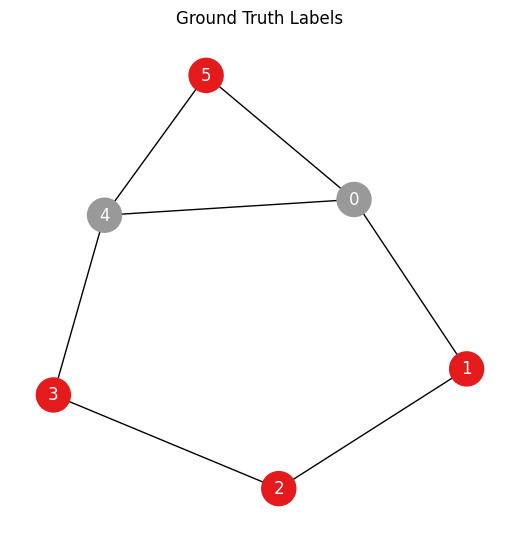

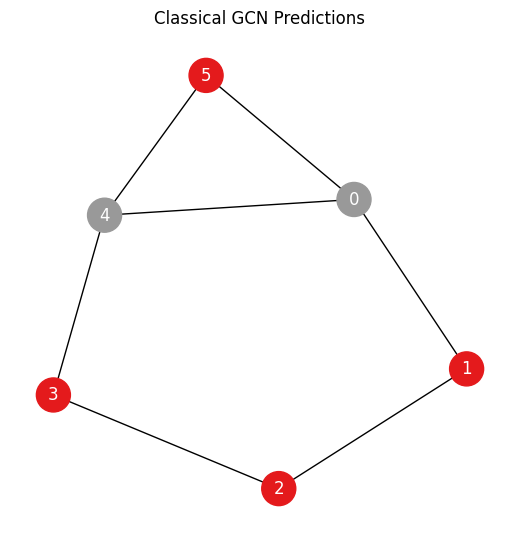

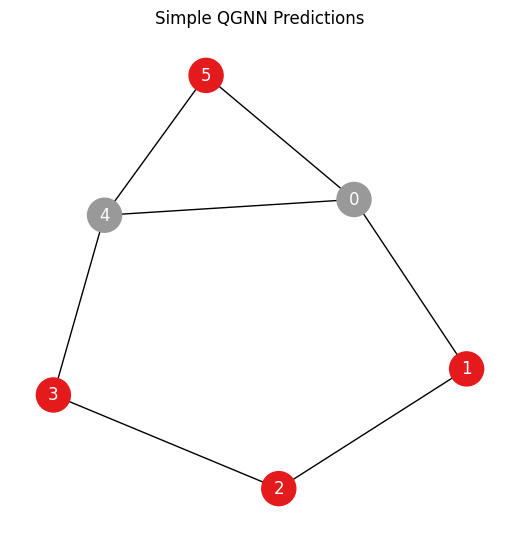

Classical GCN parameters: 162
Simple QGNN parameters: 388
Classical layers: 2 (GCNConv layers)
Simple QGNN layers: 1 quantum layer + 2 MLP layers


In [16]:
# Training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(classical_train_losses, label="Classical GCN")
plt.plot(simple_qgnn_train_losses, label="Simple QGNN")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot([a*100 for a in classical_train_accs], label="Classical GCN")
plt.plot([a*100 for a in simple_qgnn_train_accs], label="Simple QGNN")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# Confusion matrices
def plot_confusion(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion(classical_cm, "Classical GCN Confusion Matrix")
plot_confusion(simple_qgnn_cm, "Simple QGNN Confusion Matrix")

# Node-level predictions vs ground truth
sample_test_data = test_dataset[0].to(device)
classical_model.eval()
simple_qgnn.eval()
with torch.no_grad():
    classical_logits = classical_model(sample_test_data).argmax(dim=1).cpu().numpy()
    qgnn_logits = simple_qgnn(sample_test_data).argmax(dim=1).cpu().numpy()
true_labels = sample_test_data.y.cpu().numpy()

G_sample = to_networkx(sample_test_data, to_undirected=True)
pos = nx.spring_layout(G_sample, seed=42)

def plot_prediction_graph(G, labels, title="Graph", pos=None):
    plt.figure(figsize=(5,5))
    cmap = plt.cm.Set1
    nx.draw(G, pos, with_labels=True, node_color=labels, cmap=cmap, node_size=600, font_color='white')
    plt.title(title)
    plt.show()

plot_prediction_graph(G_sample, true_labels, "Ground Truth Labels", pos)
plot_prediction_graph(G_sample, classical_logits, "Classical GCN Predictions", pos)
plot_prediction_graph(G_sample, qgnn_logits, "Simple QGNN Predictions", pos)

# Parameters & layers
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Classical GCN parameters: {count_parameters(classical_model)}")
print(f"Simple QGNN parameters: {count_parameters(simple_qgnn)}")
print("Classical layers: 2 (GCNConv layers)")
print("Simple QGNN layers: 1 quantum layer + 2 MLP layers")


In [17]:
print("Classical GCN Test Accuracy:", round(classical_test_acc*100,2))
print("Simple QGNN Test Accuracy:", round(simple_qgnn_test_acc*100,2))
print("\nClassical GCN Classification Report:\n", classical_cr)
print("Simple QGNN Classification Report:\n", simple_qgnn_cr)


Classical GCN Test Accuracy: 96.67
Simple QGNN Test Accuracy: 100.0

Classical GCN Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9500    0.9744        80
           1     0.9091    1.0000    0.9524        40

    accuracy                         0.9667       120
   macro avg     0.9545    0.9750    0.9634       120
weighted avg     0.9697    0.9667    0.9670       120

Simple QGNN Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        80
           1     1.0000    1.0000    1.0000        40

    accuracy                         1.0000       120
   macro avg     1.0000    1.0000    1.0000       120
weighted avg     1.0000    1.0000    1.0000       120

